<a href="https://colab.research.google.com/github/xia0405/Master-thesis-NLP/blob/master/Amazon_sentiment_analysis_from_Scratch_bow_Tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook will do sentiment analysis with the traditional way. 
- To create features, both bag-of-words and tfidf are used to compare the results.
- Traditional classifiers like Naive Bayes model and logistic regression model for this task. 

In the next notebook I will use modern NLP methods, like word-embeddings and neural networks to do the same task.

In [0]:
# import necessary libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd

from collections import Counter

# text preprocessing
import re
import spacy
nlp = spacy.load('en')
from scipy import sparse as sp_sparse

# sklearn modules
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix

# Visualization modules
import matplotlib.pyplot as plt
import wordcloud

In [0]:
from fastai import *
from fastai.text import *

In [0]:
# read the data
train= pd.read_csv('/content/drive/My Drive/data/amazon/train.csv')
test= pd.read_csv('/content/drive/My Drive/data/amazon/test.csv')

In [8]:
train.head()

,overall,reviewText
0,0,Didn't like the fact the numbers were stitched...
1,0,"While these did protect my carbon-soled shoes,..."
2,0,Mine was another roller cut in half. I could h...
3,0,"I have to agree with Plachno on this one, but ..."
4,0,"Second pair I have, this pair has an elastic b..."


In [7]:
train['reviewText']

0         Didn't like the fact the numbers were stitched...
1         While these did protect my carbon-soled shoes,...
2         Mine was another roller cut in half. I could h...
3         I have to agree with Plachno on this one, but ...
4         Second pair I have, this pair has an elastic b...
                                ...                        
159995    Nice thick socks but a single wear and they re...
159996              Magpul items are always a quality item.
159997    Nice scales! The only reason I didn't give the...
159998    I bought this knife out of curiosity and borde...
159999    Haven't had to use it yet as I bought it as a ...
Name: reviewText, Length: 160000, dtype: object

In [12]:
train['reviewText'].values

array(["Didn't like the fact the numbers were stitched on and the stitching started coming apart the first time out. Got a refund.",
       'While these did protect my carbon-soled shoes, they caused me considerable problems clipping in. I had ridden eggbeaters for many years before buying these. Clipping in was second nature. After installing these, I found it next to impossible to clip in.\n\nMy method:\n- Reach down, touch the pedal with my foot, toe slightly up\n- pull foot back, hooking the back of the cleat in the pedal\n- press down to fully engage\n\nAll this happens quickly, while pedaling. With these, my "pull back" hooks the pedal on the edge of the shield, instead of the cleat.\n\nIt\'s not necessarily a bad product, just not for me.',
       "Mine was another roller cut in half. I could have done that myself - wanted something that looked more finished. Returned it to the company with the RMA number and I don't think that my refund ever showed up. I don't care enough to ch

In [14]:
test['overall'].values

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
# Seperate the input and labels X_train, y_train, X_test, y_test
X_train, y_train = train['reviewText'].values, train['overall'].values
X_test, y_test = test['reviewText'].values, test['overall'].values

In [141]:
# print the dimensions 
print(f"X_train length: {len(X_train)}\ny_train length: {len(y_train)} \nX_test length: {len(X_test)}\ny_test length: {len(y_test)}")

X_train length: 160000
y_train length: 160000 
X_test length: 40000
y_test length: 40000


In [0]:
# create a cloud visualization of the data
cloud = wordcloud.WordCloud(background_color='white', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(train.reviewText))

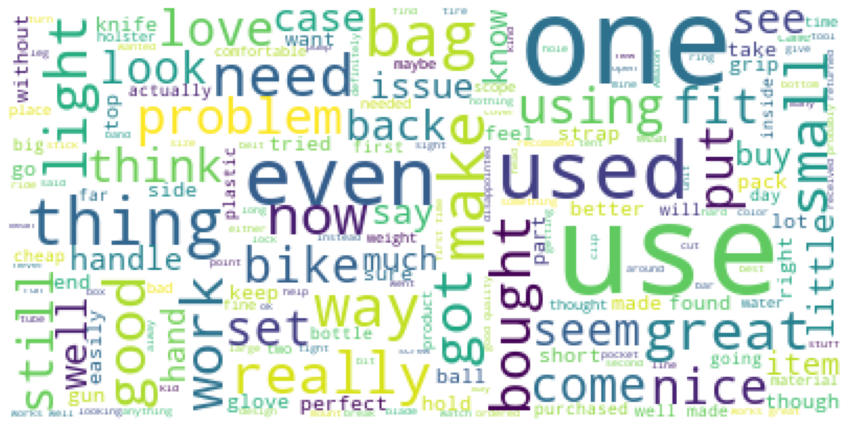

In [132]:
fig = plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(cloud);

### Step 1: Preprocessing text
Text are unstructured data. In NLP, the first step is tokenize them. Reviews are composed of lists of tokens. A **token** is the basic unit of processing (what the tokens are depends on the application and your choices). Here, the tokens mostly correspond to words or punctuation, as well as several special tokens, corresponding to unknown words, capitalization, etc.
#### 1.1 Tokenize
I use the [**fastai** tokenizer ](https://docs.fast.ai/text.transform.html#Tokenizer) which is based on the powerful Spacy tokenizer.   
`defaults.text_pre_rules = [fix_html, replace_rep, replace_wrep, spec_add_spaces, rm_useless_spaces]`


In [24]:
# before tokenization
X_train[:3]

array(["Didn't like the fact the numbers were stitched on and the stitching started coming apart the first time out. Got a refund.",
       'While these did protect my carbon-soled shoes, they caused me considerable problems clipping in. I had ridden eggbeaters for many years before buying these. Clipping in was second nature. After installing these, I found it next to impossible to clip in.\n\nMy method:\n- Reach down, touch the pedal with my foot, toe slightly up\n- pull foot back, hooking the back of the cleat in the pedal\n- press down to fully engage\n\nAll this happens quickly, while pedaling. With these, my "pull back" hooks the pedal on the edge of the shield, instead of the cleat.\n\nIt\'s not necessarily a bad product, just not for me.',
       "Mine was another roller cut in half. I could have done that myself - wanted something that looked more finished. Returned it to the company with the RMA number and I don't think that my refund ever showed up. I don't care enough to ch

In [0]:
tokenizer = Tokenizer()
# preprocess the reviews using class Tokenizer
tokens_train = tokenizer.process_all(X_train)
tokens_test = tokenizer.process_all(X_test)

# put tokens back to a sentence 
X_train = [' '.join(tokens_train[x]) for x in range(len(tokens_train))]
X_test = [' '.join(tokens_test[x]) for x in range(len(tokens_test))]

In [11]:
X_train[:3]

["xxmaj did n't like the fact the numbers were stitched on and the stitching started coming apart the first time out . xxmaj got a refund .",
 'xxmaj while these did protect my carbon - soled shoes , they caused me considerable problems clipping in . i had ridden eggbeaters for many years before buying these . xxmaj clipping in was second nature . xxmaj after installing these , i found it next to impossible to clip in . \n \n  xxmaj my method : \n  - xxmaj reach down , touch the pedal with my foot , toe slightly up \n  - pull foot back , hooking the back of the cleat in the pedal \n  - press down to fully engage \n \n  xxmaj all this happens quickly , while pedaling . xxmaj with these , my " pull back " hooks the pedal on the edge of the shield , instead of the cleat . \n \n  xxmaj it \'s not necessarily a bad product , just not for me .',
 "xxmaj mine was another roller cut in half . i could have done that myself - wanted something that looked more finished . xxmaj returned it to the 

**Special tokens**:
All those tokens starting with "xx" are fastai special tokens.  You can see the list of all of them and their meanings ([in the fastai docs](https://docs.fast.ai/text.transform.html)): 

#### 1.2 Numericalization of tokens
For each word calculate how many times they occur in the train corpus

In [0]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

words = [X_train[i].split() for i in range(len(X_train))]
freq_words = Counter(token for group in words for token in group)
words_counts = dict(freq_words)


In [13]:
# the most common words
freq_words.most_common(10)

[('xxmaj', 594832),
 ('.', 559884),
 ('the', 444114),
 ('i', 287746),
 (',', 267157),
 ('it', 240797),
 ('a', 232835),
 ('and', 229771),
 ('to', 221950),
 ('is', 134948)]

In [14]:
sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

[('xxmaj', 594832),
 ('.', 559884),
 ('the', 444114),
 ('i', 287746),
 (',', 267157),
 ('it', 240797),
 ('a', 232835),
 ('and', 229771),
 ('to', 221950),
 ('is', 134948)]

##### Bag-of-words from Scratch as the first simple approach 

In [0]:
# create the bag-of-words itos = [o for o,c in freq.most_common(max_vocab) if c>= min_freq]

max_vocab = 5000
# create a dictionary of tokens to index and a list of index to tokens
WORDS_TO_INDEX = {k: v for v, k in enumerate([o for o,_ in freq_words.most_common(max_vocab)])} 
INDEX_TO_WORDS = dict(enumerate([o for o,_ in freq_words.most_common(max_vocab)]))
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, max_vocab):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(max_vocab)

    all_words = words_to_index.keys()
    for word in text.split():
        if word in all_words:
            result_vector[words_to_index[word]] += 1
      
    return result_vector

In [16]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, max_vocab)) for text in X_train])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, max_vocab)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (160000, 5000)
X_test shape  (40000, 5000)


In [17]:
row = X_train_mybag[10].toarray()[0]
row

array([2., 1., 1., 0., ..., 0., 0., 0., 0.])

##### Use sklearn CountVectorizer

In [0]:
# or use sklearn CountVectorizer
def bow_features(X_train,X_test):
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(2, 2)) 
  # Fit the vectorizer on the train set
  X_train= vectorizer.fit_transform(X_train)
  # Transform the train and test sets and return the result
  X_test = vectorizer.transform(X_test)
    
  return X_train, X_test, vectorizer.vocabulary_

In [84]:
X_train_bow, X_test_bow, bow_vocab = bow_features(X_train, X_test)
bow_reversed_vocab = {i:word for word,i in bow_vocab.items()}

print('X_train shape ', X_train_bow.shape)
print('X_test shape ', X_test_bow.shape)

X_train shape  (160000, 169076)
X_test shape  (40000, 169076)


In [57]:
row = X_train_bow[10].toarray()[0]
row

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

##### TF-IDF 
The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [0]:
def tfidf_features(X_train, X_test):
    """
        X_train, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9,ngram_range=(1,2))####### YOUR CODE HERE #######
    
    # Fit the vectorizer on the train set
    X_train= tfidf_vectorizer.fit_transform(X_train)
    # Transform the train and test sets and return the result
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_test, tfidf_vectorizer.vocabulary_

In [59]:
X_train_tfidf,X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

print('X_train shape ', X_train_tfidf.shape)
print('X_test shape ', X_test_tfidf.shape)

X_train shape  (160000, 188756)
X_test shape  (40000, 188756)


In [60]:
row =X_train_tfidf[10].toarray()[0]
row

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])

### Step 2: Classifiers

In [0]:
def get_classifier(models=dict()):
    models['Logistic Regression'] = LogisticRegression()
    models['Multinomia Naive Bayes'] = MultinomialNB()

    print('Defined %d models' % len(models))
    return models


In [0]:
def n_gram(ngram=dict()):
  # unigram
  ngram['unigram']=1
  # bigram
  ngram['bigram']=2
  # trigram
  ngram['trigram']=3 
  return ngram

In [0]:
# create vectorizer for bag-of-words and tf-idf.
def get_vectorizer(ngram):
  vectorizer=dict()
  vectorizer['Bag of words'] = CountVectorizer(min_df=5, max_df=20000, ngram_range= (ngram,ngram))
  vectorizer['TF-IDF vectorizer'] = TfidfVectorizer(min_df=5, max_df=20000,ngram_range= (ngram,ngram))
  return vectorizer

In [0]:
def train_classifier(vectorizer, classifier, X_train, y_train ):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    # define a pipeline ## max_df=0.9
    pipeline = Pipeline([
     ('vect', vectorizer),
     ('clf', classifier)])

    text_clf = pipeline.fit(X_train, y_train)
    return text_clf

In [0]:
def evaluation_scores(vectorizer, classifier, X_train, y_train, X_test, y_test, classifier_name, vectorizer_name):

  
  trained_classifier = train_classifier(vectorizer, classifier, X_train, y_train)

  y_pred_test = trained_classifier.predict(X_test)
  y_pred_train = trained_classifier.predict(X_train) 
  

  accuracy_test = accuracy_score(y_test, y_pred_test)
  accuracy_train = accuracy_score(y_train, y_pred_train)

  #print(f'{classifier_name}\t{vectorizer_name}')
  
  #print('TRAIN : Accuracy: %.4f ,TEST : Accuracy: %.4f' % ( accuracy_train,accuracy_test))
  #print('---------------------')

  return accuracy_test

In [231]:
%%time
accuracy_total = []
accuracy_test_scores = dict()
# prepare the models to evaluate
models = get_classifier()
ngrams = n_gram()

for ngram_name, n in ngrams.items():
  vectorizers = get_vectorizer(n)
  for v_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
      accuracy_test = evaluation_scores(vectorizer, model, X_train, y_train, X_test, y_test, model_name, v_name)
      accuracy_test_scores['accuracy_test'] =accuracy_test
      accuracy_test_scores['model'] = model_name
      accuracy_test_scores['vectorizer'] = v_name
      accuracy_test_scores['ngram'] = ngram_name
      print(accuracy_test_scores)
      #accuracy_total.append(accuracy_test_scores)

Defined 2 models


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'accuracy_test': 0.849975, 'model': 'Logistic Regression', 'vectorizer': 'Bag of words', 'ngram': 'unigram'}
{'accuracy_test': 0.818625, 'model': 'Multinomia Naive Bayes', 'vectorizer': 'Bag of words', 'ngram': 'unigram'}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'accuracy_test': 0.86115, 'model': 'Logistic Regression', 'vectorizer': 'TF-IDF vectorizer', 'ngram': 'unigram'}
{'accuracy_test': 0.83155, 'model': 'Multinomia Naive Bayes', 'vectorizer': 'TF-IDF vectorizer', 'ngram': 'unigram'}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'accuracy_test': 0.899925, 'model': 'Logistic Regression', 'vectorizer': 'Bag of words', 'ngram': 'bigram'}
{'accuracy_test': 0.886725, 'model': 'Multinomia Naive Bayes', 'vectorizer': 'Bag of words', 'ngram': 'bigram'}
{'accuracy_test': 0.9025, 'model': 'Logistic Regression', 'vectorizer': 'TF-IDF vectorizer', 'ngram': 'bigram'}
{'accuracy_test': 0.891575, 'model': 'Multinomia Naive Bayes', 'vectorizer': 'TF-IDF vectorizer', 'ngram': 'bigram'}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'accuracy_test': 0.86215, 'model': 'Logistic Regression', 'vectorizer': 'Bag of words', 'ngram': 'trigram'}
{'accuracy_test': 0.852825, 'model': 'Multinomia Naive Bayes', 'vectorizer': 'Bag of words', 'ngram': 'trigram'}
{'accuracy_test': 0.869925, 'model': 'Logistic Regression', 'vectorizer': 'TF-IDF vectorizer', 'ngram': 'trigram'}
{'accuracy_test': 0.856225, 'model': 'Multinomia Naive Bayes', 'vectorizer': 'TF-IDF vectorizer', 'ngram': 'trigram'}
CPU times: user 8min 7s, sys: 36.2 s, total: 8min 43s
Wall time: 8min 4s


In [232]:
accuracy_total

[]

In [0]:
pd.DataFrame(accuracy_total)

In [0]:
pd.DataFrame(accuracy_total).to_csv('/content/drive/My Drive/data/amazon/accuracy_total.tsv', sep = '\t')

Train the NB for different data transformations: *bag-of-words* and *tf-idf*.

In [0]:
nb_clf_mybag = train_classifier(nb_clf,X_train_bow, y_train)
nb_clf_tfidf = train_classifier(nb_clf,X_train_tfidf, y_train)

In [0]:
X_train_bow.shape

(160000, 188756)

In [0]:
y_train.shape

(160000,)

In [0]:
X_test_bow.shape

(40000, 169076)

Prediction on the test dataset

Train LR for different data transformations: bag-of-words and tf-idf.

### Step 3: Evaluation
To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)


In [0]:
def print_evaluation_scores(y_val, predicted):
  accuracy = accuracy_score(y_val, predicted)
  print('accuracy:\t{}'.format(accuracy))

In [54]:
print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf_lr)

Tfidf
accuracy:	0.91095


In [106]:
print(lr_clf_tfidf.coef_)

[[-1.906982 -0.293005 -0.172443 -0.08912  ... -0.056129 -0.002312 -0.096576 -0.108684]]


In [125]:
coef = lr_clf_tfidf.coef_

top_positive_words = [tfidf_reversed_vocab[list(coef[0]).index(i)] for i in sorted(coef[0], reverse=True)[:15]]# top-5 words sorted by the coefficiens.
top_negative_words = [tfidf_reversed_vocab[list(coef[0]).index(i)] for i in sorted(coef[0], reverse=True)[-15:]]# bottom-5 words  sorted by the coefficients.
print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

Top positive words:	great, perfect, love, not bad, nice, perfectly, excellent, little, well, awesome, good, not too, the only, does what, bit
Top negative words:	poorly, two stars, not recommend, not good, terrible, returning, not worth, return, junk, poor, disappointed, returned, useless, broke, not

